# Projet Machine Learning Transilien 

## Import des librairies

In [2]:
# pour traiter les tables de données

import pandas as pd
import numpy as np

# pour réaliser des visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# geographiques
# from shapely.geometry import Point
# import geopandas as gpd
# from geopandas import GeoDataFrame

# pour pré-traiter les données
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.cluster import KMeans
from kneed import KneeLocator

from sklearn.model_selection import  cross_val_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold,TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import  mean_absolute_error

from sklearn.decomposition import PCA





## Import du dataset et description

Ce dataset représente des données des Trains Transiliens de la SNCF anonymisées

In [3]:
dfTrain = pd.read_csv("/Users/juloo/Desktop/Cours/Data_1/Machine_Learning/Challenge/Datas/x_train_final.csv",sep=",")
dfTest = pd.read_csv("/Users/juloo/Desktop/Cours/Data_1/Machine_Learning/Challenge/Datas/x_test_final.csv",sep=",")
y_train_final = pd.read_csv("/Users/juloo/Desktop/Cours/Data_1/Machine_Learning/Challenge/Datas/y_train_final_j5KGWWK.csv",sep=",")

dfTrain['retard'] = y_train_final['p0q0']

## Informations initiales 

In [4]:
dfTrain.head()

,Unnamed: 0.1,Unnamed: 0,train,gare,date,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4,retard
0,0,0,VBXNMF,KYF,2023-04-03,8,0.0,0.0,1.0,-3.0,-1.0,-2.0,-1.0
1,1,1,VBXNMF,JLR,2023-04-03,9,0.0,0.0,0.0,1.0,0.0,1.0,-1.0
2,2,2,VBXNMF,EOH,2023-04-03,10,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0
3,3,3,VBXNMF,VXY,2023-04-03,11,-1.0,-1.0,0.0,2.0,-2.0,0.0,1.0
4,4,4,VBXNMF,OCB,2023-04-03,12,-1.0,-1.0,-1.0,-1.0,3.0,2.0,3.0


In [5]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667264 entries, 0 to 667263
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0.1  667264 non-null  int64  
 1   Unnamed: 0    667264 non-null  int64  
 2   train         667264 non-null  object 
 3   gare          667264 non-null  object 
 4   date          667264 non-null  object 
 5   arret         667264 non-null  int64  
 6   p2q0          667264 non-null  float64
 7   p3q0          667264 non-null  float64
 8   p4q0          667264 non-null  float64
 9   p0q2          667264 non-null  float64
 10  p0q3          667264 non-null  float64
 11  p0q4          667264 non-null  float64
 12  retard        667264 non-null  float64
dtypes: float64(7), int64(3), object(3)
memory usage: 66.2+ MB


In [6]:
dfTrain.describe()

,Unnamed: 0.1,Unnamed: 0,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4,retard
count,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000
mean,333631.500000,333631.500000,18.277499,-0.170696,-0.167304,-0.176308,-0.163223,-0.173579,-0.174436,-0.159950
std,192622.669348,192622.669348,7.030424,1.976521,1.960416,1.926275,1.988527,2.643148,4.732999,1.987872
min,0.000000,0.000000,7.000000,-160.000000,-160.000000,-160.000000,-160.000000,-1441.000000,-1441.000000,-160.000000
25%,166815.750000,166815.750000,12.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,333631.500000,333631.500000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,500447.250000,500447.250000,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,667263.000000,667263.000000,42.000000,14.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000


#### Informations à tirer des colonnes numériques

In [7]:
# certaines colonnes ne sont pas numériques. On créé un autre dataframe uniquement numérique pour observer leur distribution
dfTrainNum = dfTrain.drop(columns=['Unnamed: 0','Unnamed: 0.1','train','gare','date'])
dfTrainNum.corr()

,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4,retard
arret,1.000000,0.015472,0.002979,-0.018653,0.045734,0.026330,0.017524,0.045075
p2q0,0.015472,1.000000,0.439502,-0.052613,0.082190,0.048465,0.014294,-0.052890
p3q0,0.002979,0.439502,1.000000,0.437139,0.106473,0.098490,0.046044,0.025357
p4q0,-0.018653,-0.052613,0.437139,1.000000,0.113606,0.095052,0.049390,0.039447
p0q2,0.045734,0.082190,0.106473,0.113606,1.000000,0.194316,0.117637,0.277717
p0q3,0.026330,0.048465,0.098490,0.095052,0.194316,1.000000,0.081587,0.156384
p0q4,0.017524,0.014294,0.046044,0.049390,0.117637,0.081587,1.000000,0.085419
retard,0.045075,-0.052890,0.025357,0.039447,0.277717,0.156384,0.085419,1.000000


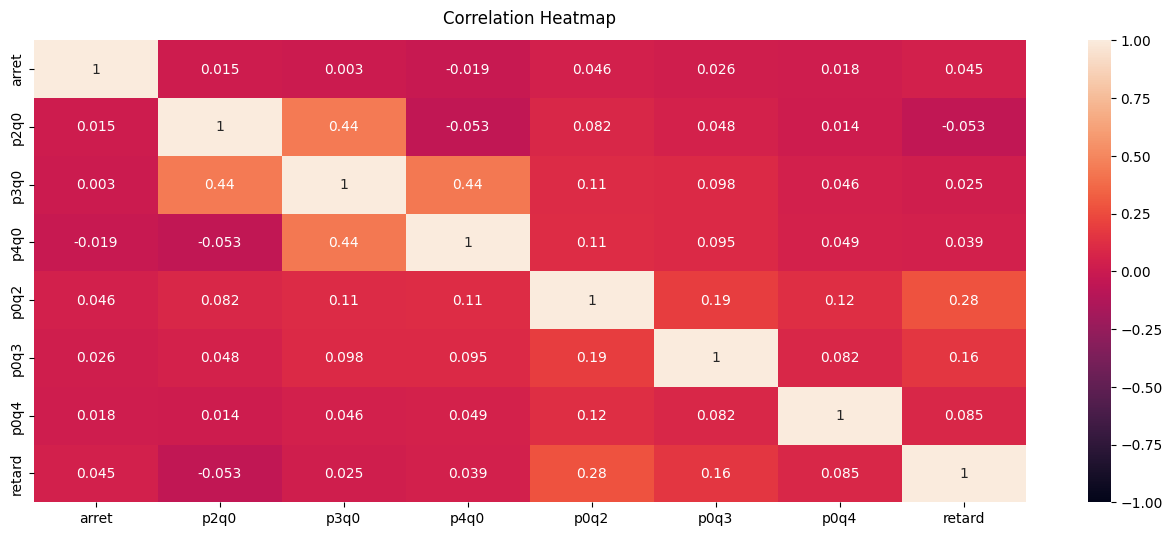

In [8]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfTrainNum.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [9]:
dfTrain.describe()

,Unnamed: 0.1,Unnamed: 0,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4,retard
count,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000,667264.000000
mean,333631.500000,333631.500000,18.277499,-0.170696,-0.167304,-0.176308,-0.163223,-0.173579,-0.174436,-0.159950
std,192622.669348,192622.669348,7.030424,1.976521,1.960416,1.926275,1.988527,2.643148,4.732999,1.987872
min,0.000000,0.000000,7.000000,-160.000000,-160.000000,-160.000000,-160.000000,-1441.000000,-1441.000000,-160.000000
25%,166815.750000,166815.750000,12.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,333631.500000,333631.500000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,500447.250000,500447.250000,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,667263.000000,667263.000000,42.000000,14.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000


## Feature engineering

### Gestion des valeurs manquantes

In [10]:
dfTrain.isna().sum()

Unnamed: 0.1    0
Unnamed: 0      0
train           0
gare            0
date            0
arret           0
p2q0            0
p3q0            0
p4q0            0
p0q2            0
p0q3            0
p0q4            0
retard          0
dtype: int64

### Suppression des colonnes inutiles

In [11]:
dfTrain = dfTrain.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
dfTest = dfTest.drop(columns=['Unnamed: 0'])

#### Visualisation des retards moyens par jour

<Figure size 1200x600 with 0 Axes>

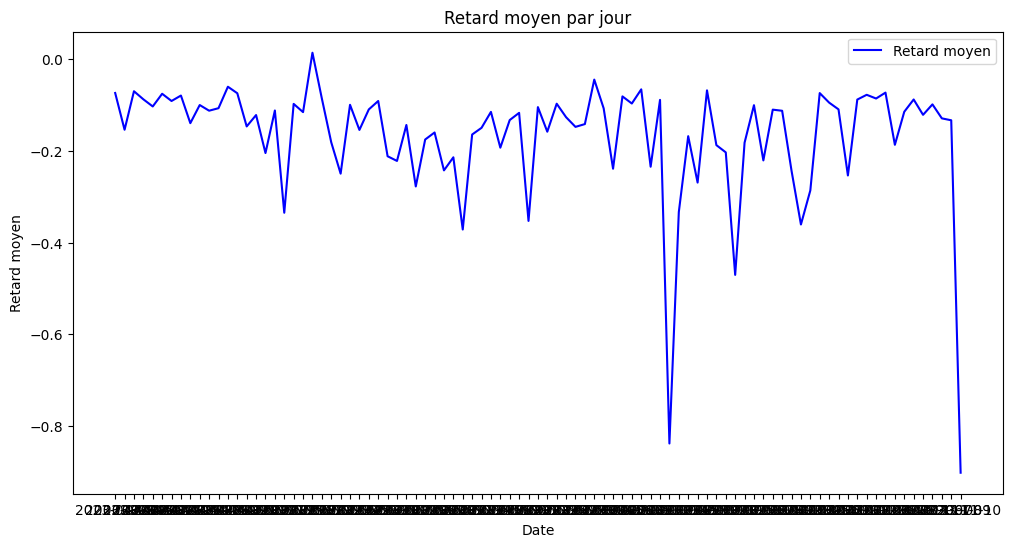

In [12]:
#Graphiques des retards dans le temps
plt.figure(figsize=(12, 6))

# Calculer les retards moyens par jour
retard_moyen_par_jour = dfTrain.groupby('date')['p0q2'].mean()

# Tracer la série temporelle des retards moyens par jour
plt.figure(figsize=(12, 6))
plt.plot(retard_moyen_par_jour.index, retard_moyen_par_jour, label="Retard moyen", color="blue")
plt.xlabel("Date")
plt.ylabel("Retard moyen")
plt.title("Retard moyen par jour")
plt.legend()
plt.show()

# plt.scatter(dfTrain[dfTrain["vacances"]]["date"], dfTrain[dfTrain["vacances"]]["retard"], 
#             color="red", label="Début des vacances")
# Ne fonctionne pas car peu de vacances 


#### Visualisation de la répartition des arrêts

<Axes: title={'center': "Nombre d'arrêts"}, xlabel='arret'>

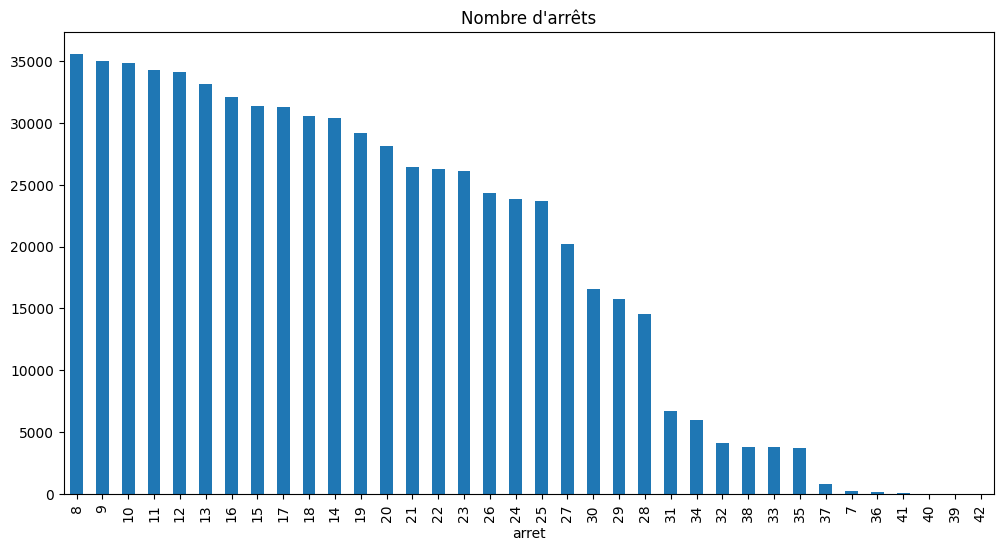

In [13]:
dfTrain['arret'].value_counts().plot(kind='bar', figsize=(12, 6), title="Nombre d'arrêts")

#### Gestion des doublons

In [14]:
# Identifier les doublons
doublons = dfTrain[dfTrain.duplicated()]

dfTrain = dfTrain.drop_duplicates()
# Afficher les doublons
print(f"Nombre de doublons : {doublons.shape[0]}")


Nombre de doublons : 0


### Gestion des outliers

<Axes: >

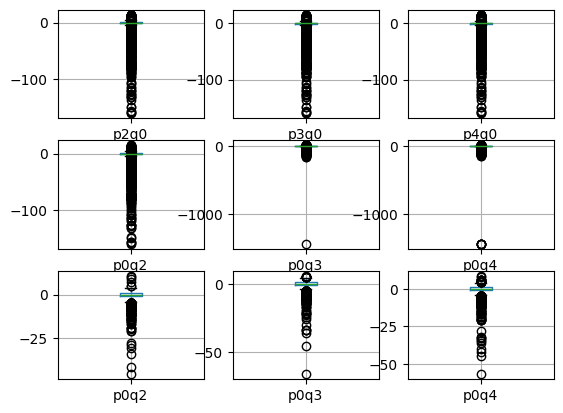

In [16]:
plt.subplot(3,3,1)
dfTrain.boxplot(column='p2q0')

plt.subplot(3,3,2)
dfTrain.boxplot(column='p3q0')

plt.subplot(3,3,3)
dfTrain.boxplot(column='p4q0')

plt.subplot(3,3,4)
dfTrain.boxplot(column='p0q2')

plt.subplot(3,3,5)
dfTrain.boxplot(column='p0q3')

plt.subplot(3,3,6)
dfTrain.boxplot(column='p0q4')

plt.subplot(3,3,7)
dfTest.boxplot(column='p0q2')

plt.subplot(3,3,8)
dfTest.boxplot(column='p0q3')

plt.subplot(3,3,9)
dfTest.boxplot(column='p0q4')



<Axes: >

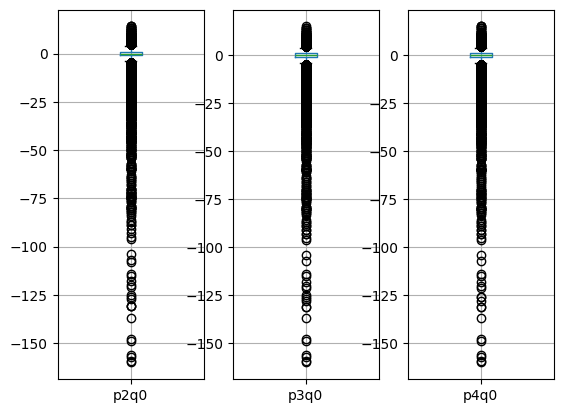

In [17]:
plt.subplot(1,3,1)
dfTrain.boxplot(column='p2q0')

plt.subplot(1,3,2)
dfTrain.boxplot(column='p3q0')

plt.subplot(1,3,3)
dfTrain.boxplot(column='p4q0')


<Axes: >

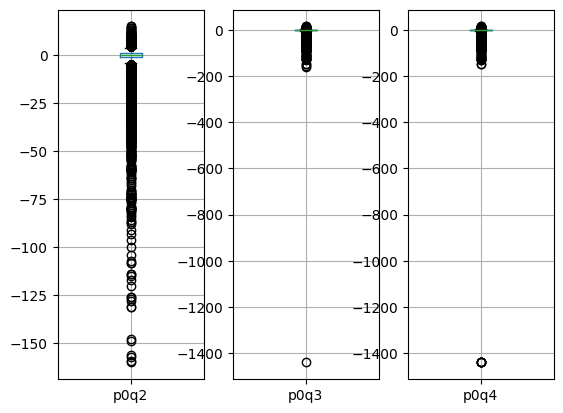

In [18]:
plt.subplot(1,3,1)
dfTrain.boxplot(column='p0q2')

plt.subplot(1,3,2)
dfTrain.boxplot(column='p0q3')

plt.subplot(1,3,3)
dfTrain.boxplot(column='p0q4')

<Axes: >

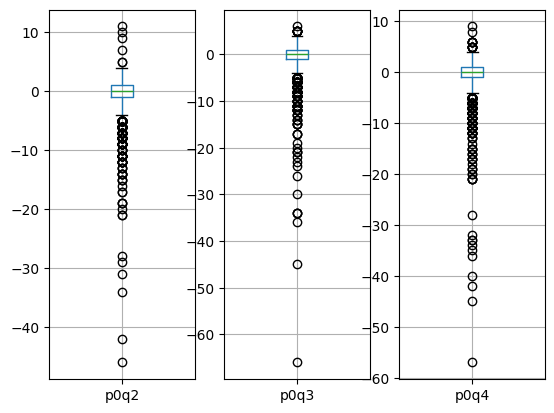

In [19]:
plt.subplot(1,3,1)
dfTest.boxplot(column='p0q2')

plt.subplot(1,3,2)
dfTest.boxplot(column='p0q3')

plt.subplot(1,3,3)
dfTest.boxplot(column='p0q4')

#### Pour voir la distribution des features 

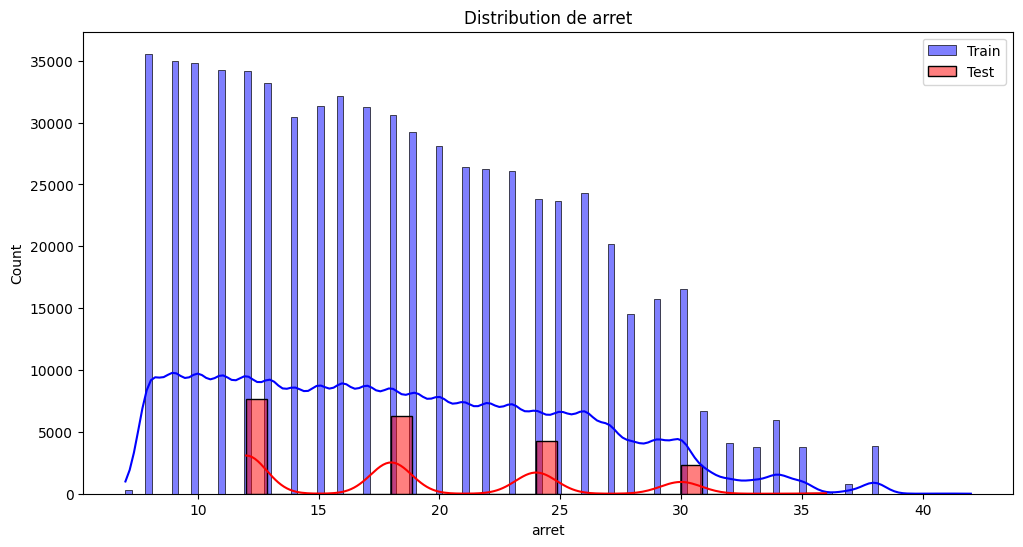

In [20]:
# Visualiser la distribution d'une feature spécifique
feature = 'arret'

plt.figure(figsize=(12, 6))
sns.histplot(dfTrain[feature], color='blue', label='Train', kde=True)
sns.histplot(dfTest[feature], color='red', label='Test', kde=True)
plt.legend()
plt.title(f'Distribution de {feature}')
plt.show()

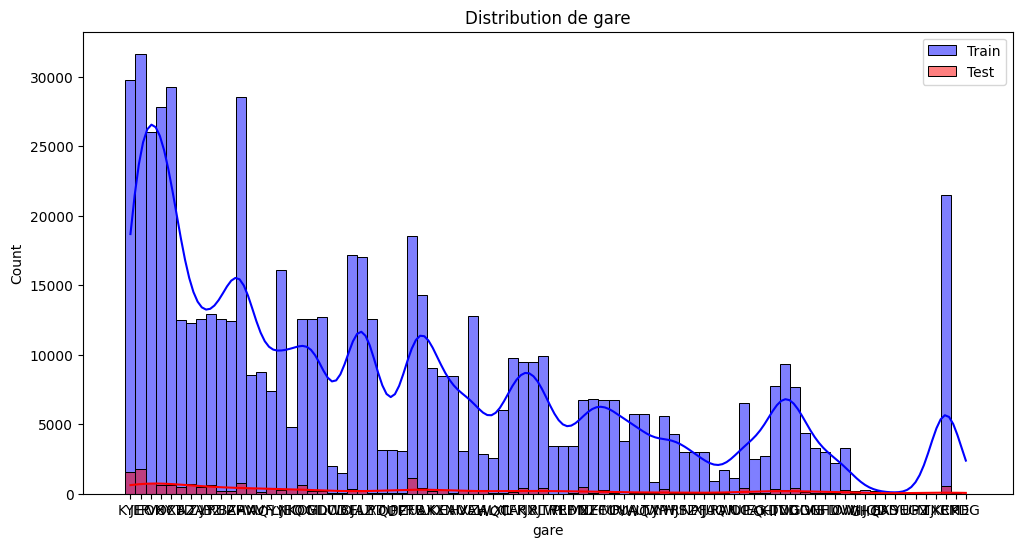

In [21]:
# Visualiser la distribution d'une feature spécifique
feature = 'gare'

plt.figure(figsize=(12, 6))
sns.histplot(dfTrain[feature], color='blue', label='Train', kde=True)
sns.histplot(dfTest[feature], color='red', label='Test', kde=True)
plt.legend()
plt.title(f'Distribution de {feature}')
plt.show()

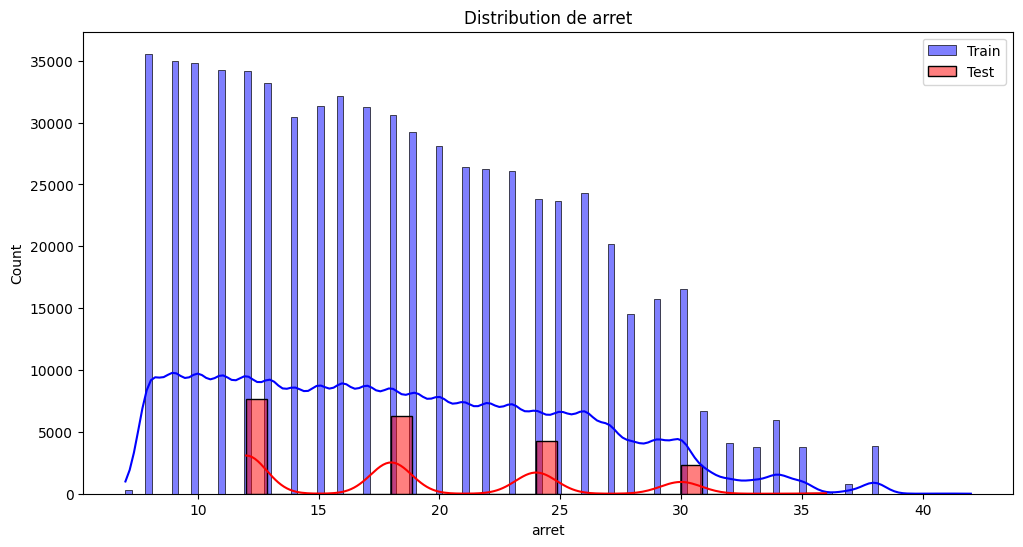

In [22]:
# Visualiser la distribution d'une feature spécifique
feature = 'arret'

plt.figure(figsize=(12, 6))
sns.histplot(dfTrain[feature], color='blue', label='Train', kde=True)
sns.histplot(dfTest[feature], color='red', label='Test', kde=True)
plt.legend()
plt.title(f'Distribution de {feature}')
plt.show()

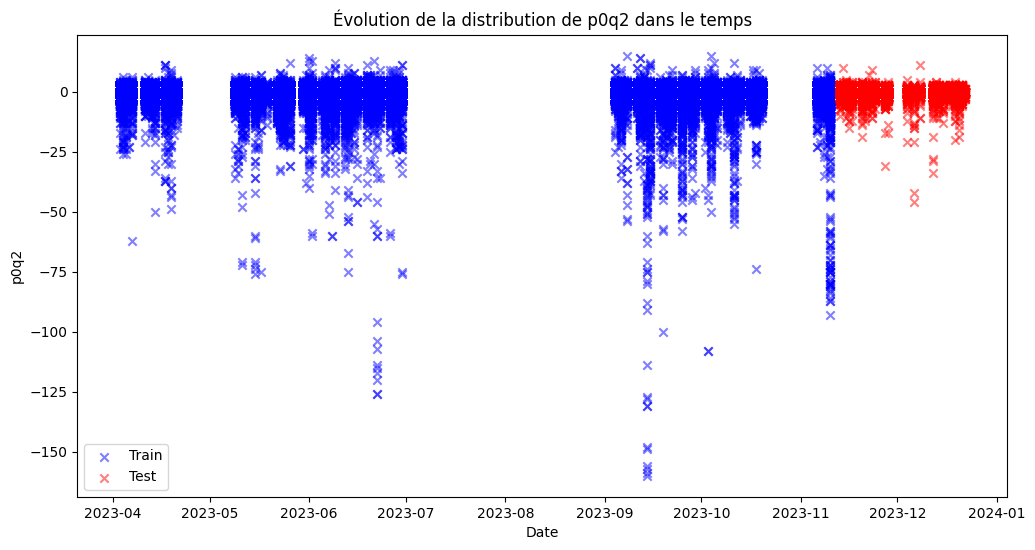

In [23]:
# Conversion str en date
dfTrain["date"] = pd.to_datetime(dfTrain["date"])

# Visualiser l'évolution de la distribution de 'p0q2' dans le temps
plt.figure(figsize=(12, 6))
plt.scatter(dfTrain["date"], dfTrain["p0q2"], alpha=0.5, marker='x', color='blue', label='Train')
plt.scatter(dfTest["date"], dfTest["p0q2"], alpha=0.5, marker='x', color='red', label='Test')
plt.xlabel("Date")
plt.ylabel("p0q2")
plt.title("Évolution de la distribution de p0q2 dans le temps")
plt.legend()
plt.show()

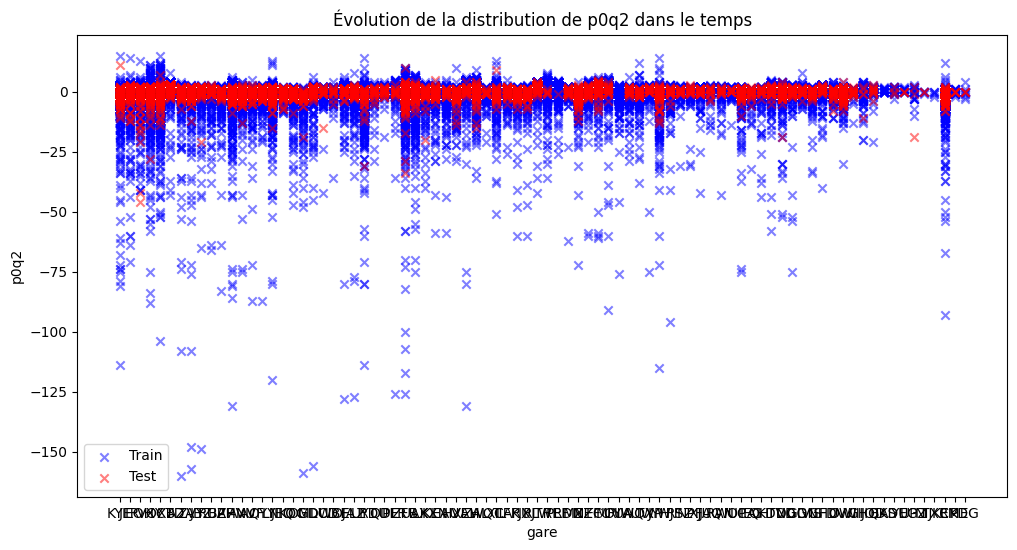

In [24]:
# Visualiser l'évolution de la distribution de 'p0q2' dans le temps
plt.figure(figsize=(12, 6))
plt.scatter(dfTrain["gare"], dfTrain["p0q2"], alpha=0.5, marker='x', color='blue', label='Train')
plt.scatter(dfTest["gare"], dfTest["p0q2"], alpha=0.5, marker='x', color='red', label='Test')
plt.xlabel("gare")
plt.ylabel("p0q2")
plt.title("Évolution de la distribution de p0q2 dans le temps")
plt.legend()
plt.show()

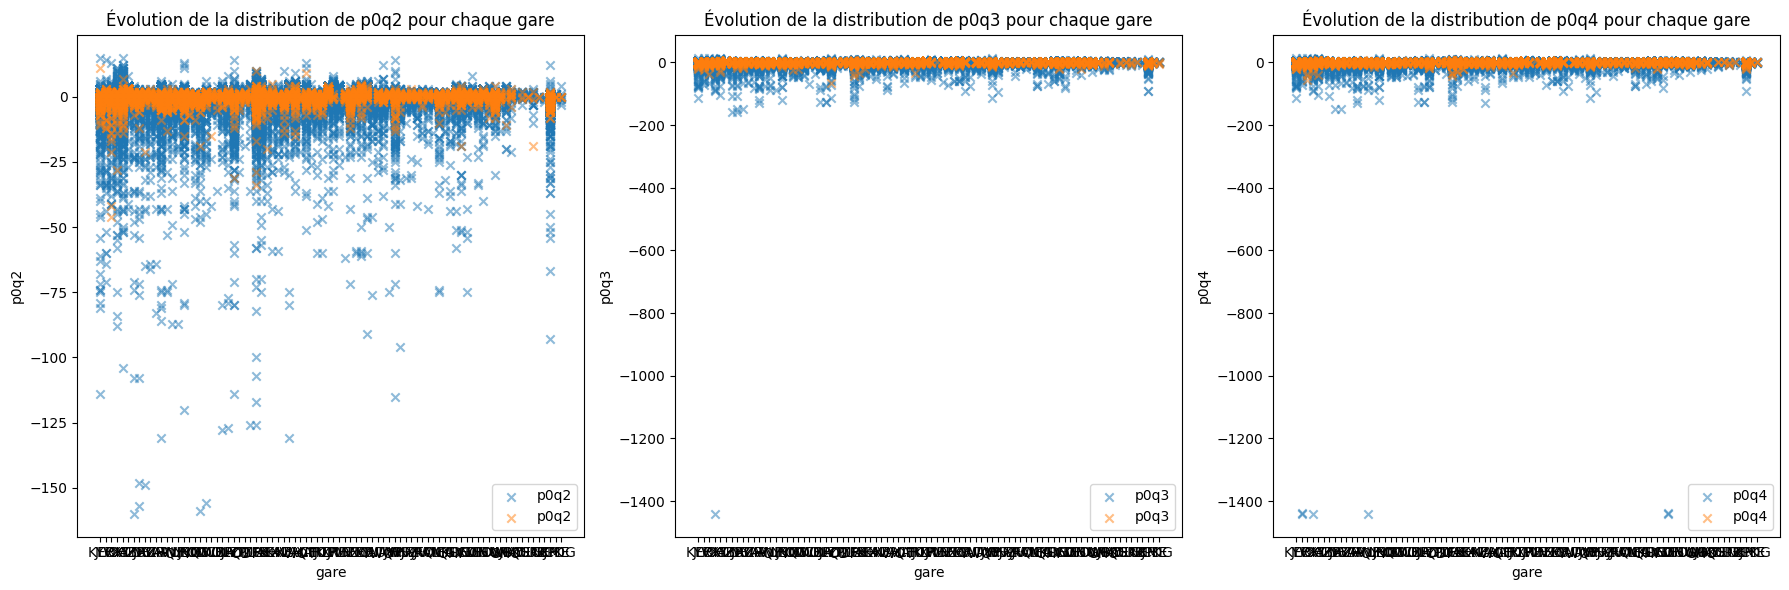

In [25]:
import pandas as pd
import matplotlib.pyplot as plt



# Visualiser l'évolution de la distribution de plusieurs variables dans le temps
variables = ['p0q2', 'p0q3', 'p0q4']
plt.figure(figsize=(18, 6))

for i, feature in enumerate(variables, 1):
    plt.subplot(1, 3, i)
    plt.scatter(dfTrain["gare"], dfTrain[feature], alpha=0.5, marker='x', label=feature)
    plt.scatter(dfTest["gare"], dfTest[feature], alpha=0.5, marker='x', label=feature)
    plt.xlabel("gare")
    plt.ylabel(feature)
    plt.title(f"Évolution de la distribution de {feature} pour chaque gare")
    plt.legend()

plt.tight_layout()
plt.show()

##### Établissement de limite adequat au jeu de test

In [26]:
lower_lim = -60
# Garder toutes les valeurs positives et les valeurs négatives qui ne sont pas des outliers
dfTrain = dfTrain[(dfTrain['p0q4'] > -50)]
dfTrain = dfTrain[(dfTrain['p0q3'] > -75)]
dfTrain = dfTrain[(dfTrain['p0q2'] > -75)]

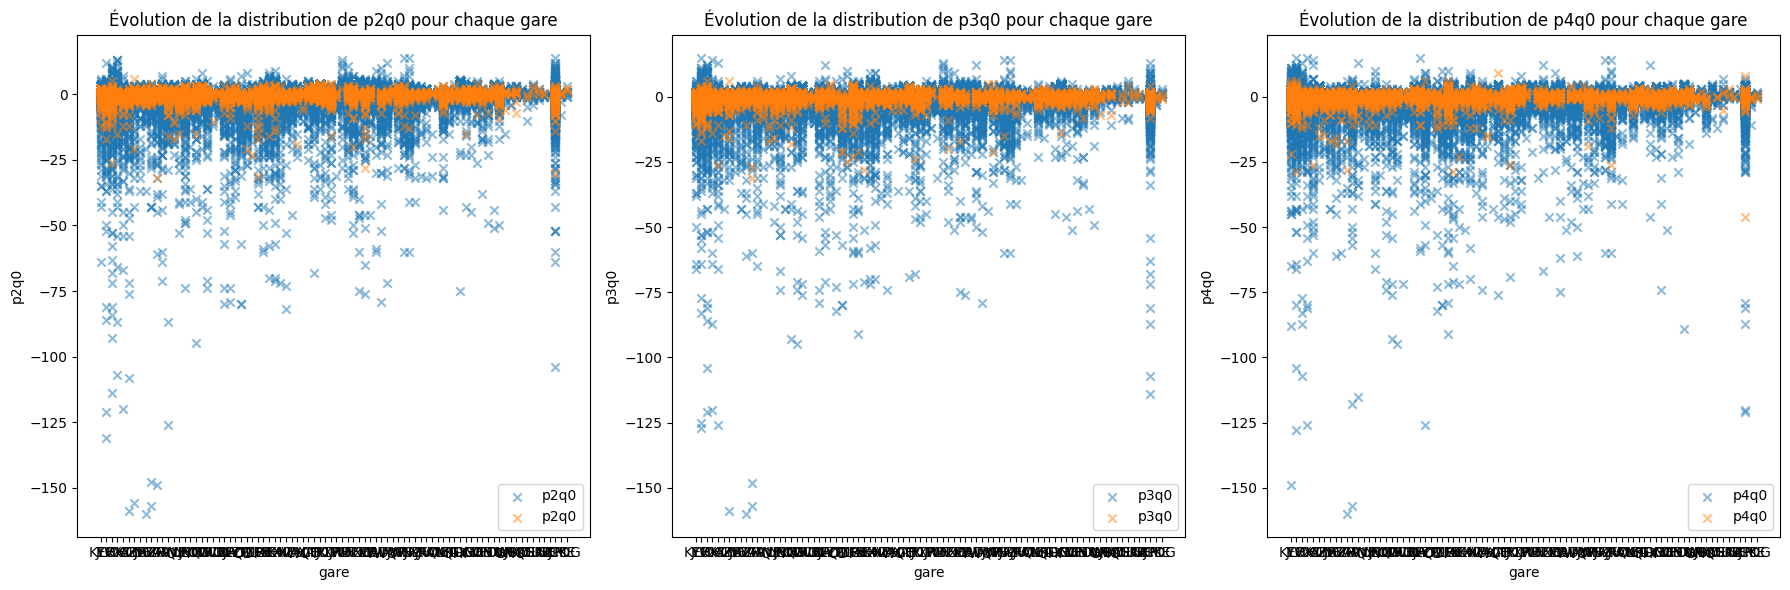

In [27]:
import pandas as pd
import matplotlib.pyplot as plt



# Visualiser l'évolution de la distribution de plusieurs variables dans le temps
variables = ['p2q0', 'p3q0', 'p4q0']
plt.figure(figsize=(18, 6))

for i, feature in enumerate(variables, 1):
    plt.subplot(1, 3, i)
    plt.scatter(dfTrain["gare"], dfTrain[feature], alpha=0.5, marker='x', label=feature)
    plt.scatter(dfTest["gare"], dfTest[feature], alpha=0.5, marker='x', label=feature)
    plt.xlabel("gare")
    plt.ylabel(feature)
    plt.title(f"Évolution de la distribution de {feature} pour chaque gare")
    plt.legend()

plt.tight_layout()
plt.show()

In [28]:
dfTrain = dfTrain[(dfTrain['p4q0'] > -50)]
dfTrain = dfTrain[(dfTrain['p3q0'] > -50)]
dfTrain = dfTrain[(dfTrain['p2q0'] > -60)]

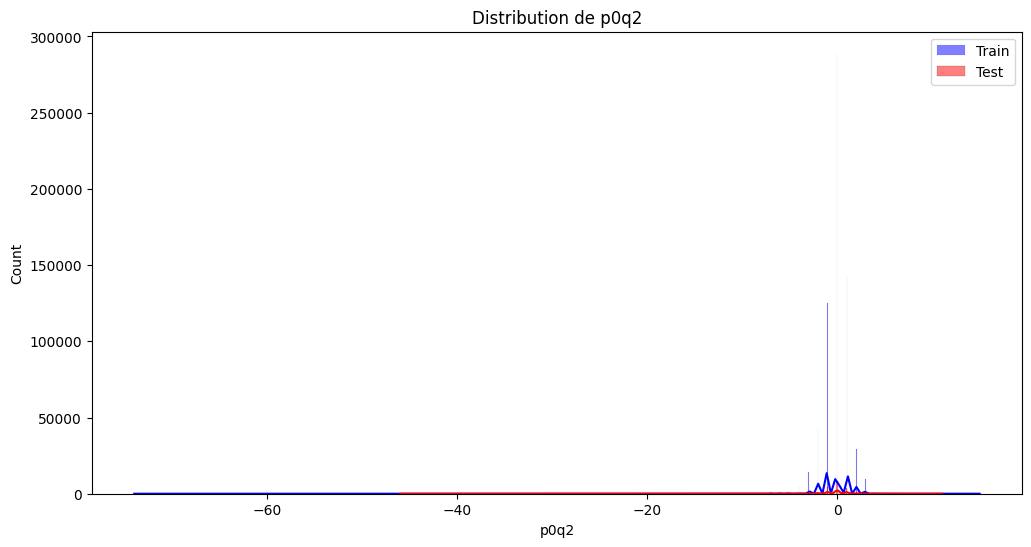

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualiser la distribution d'une feature spécifique
feature = 'p0q2'

plt.figure(figsize=(12, 6))
sns.histplot(dfTrain[feature], kde=True, color='blue', label='Train')
sns.histplot(dfTest[feature], kde=True, color='red', label='Test')
plt.legend()
plt.title(f'Distribution de {feature}')
plt.show()

#### Gestion des gares manquantes dans le jeu de test

In [30]:
gares_train = set(dfTrain["gare"].unique())
gares_test = set(dfTest["gare"].unique())

# Trouver les gares présentes dans train mais absentes du test
gares_absentes_test = gares_train - gares_test

print(f"Nombre de gares absentes dans le test : {len(gares_absentes_test)}")
print("Gares absentes :", gares_absentes_test)
dfTrain = dfTrain[~dfTrain['gare'].isin(gares_absentes_test)]

### Enlever les gares absentes dans le train


Nombre de gares absentes dans le test : 3
Gares absentes : {'BKS', 'OUA', 'TXR'}


## Feature engineering 

### Clustering -  Kmeans

#### CLustering 1

In [31]:
# Sélection des features pertinentes pour le clustering
features_clustering = ['p0q2', 'p0q3', 'p0q4', 'p2q0', 'p3q0', 'p4q0']

# Standardisation des données pour le clustering
scaler1 = StandardScaler()
X_clustering = scaler1.fit_transform(dfTrain[features_clustering])

In [32]:
# # Déterminer le nombre optimal de clusters avec la méthode du coude
# inertia = []
# K_range = range(1, 20)

# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(X_clustering)
#     inertia.append(kmeans.inertia_)

# # Tracer la méthode du coude
# plt.figure(figsize=(10, 6))
# plt.plot(K_range, inertia, marker='o')
# plt.title("Méthode du coude")
# plt.xlabel("Nombre de clusters")
# plt.ylabel("Inertia")
# plt.grid(True)
# plt.show()


# # Trouver le "coude" automatiquement
# knee_locator = KneeLocator(K_range, inertia, curve="convex", direction="decreasing")
# optimal_k = knee_locator.knee
# print(f"Nombre optimal de clusters (méthode du coude automatique) : {optimal_k}")

# # Appliquer KMeans avec le nombre optimal de clusters 
# kmeans1 = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
# dfTrain['Cluster_retard'] = kmeans1.fit_predict(X_clustering)

# # Ajouter la même feature au jeu de test
# X_clustering_test = scaler1.transform(dfTest[features_clustering])
# dfTest['Cluster_retard'] = kmeans1.predict(X_clustering_test)

# # Vérification
# print(dfTrain[['Cluster_retard']].head())
# print(dfTest[['Cluster_retard']].head())


In [33]:
# Appliquer KMeans avec le nombre optimal de clusters 
optimal_k=7
kmeans1 = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
dfTrain['Cluster_retard'] = kmeans1.fit_predict(X_clustering)

# Ajouter la même feature au jeu de test
X_clustering_test = scaler1.transform(dfTest[features_clustering])
dfTest['Cluster_retard'] = kmeans1.predict(X_clustering_test)


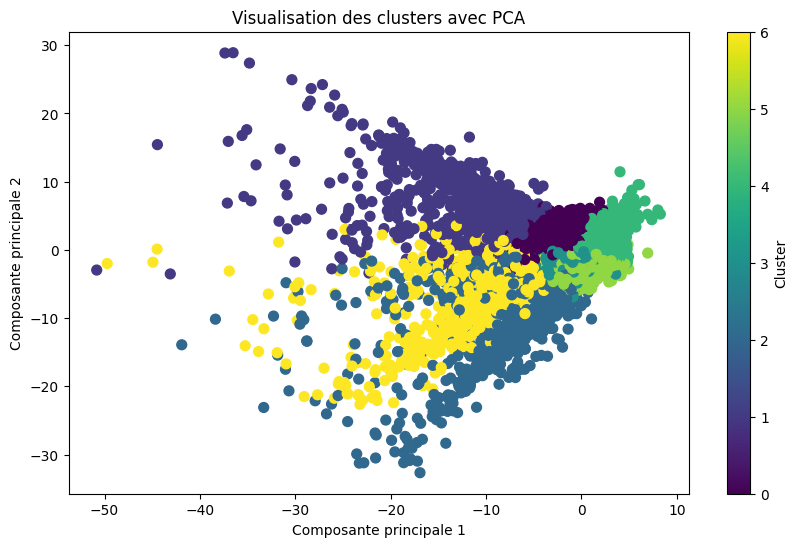

In [34]:
# Réduction à 2 dimensions avec PCA
pca = PCA(n_components=2)
X_clustering = scaler1.fit_transform(dfTrain[features_clustering])
X_pca = pca.fit_transform(X_clustering)

# Visualisation des clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dfTrain['Cluster_retard'], cmap='viridis', s=50)
plt.title("Visualisation des clusters avec PCA")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.colorbar(label="Cluster")
plt.show()

#### CLustering 2

In [35]:
# Encode 'gare' and 'train' columns using LabelEncoder

# Combiner les deux jeux de données pour entraîner le LabelEncoder
label_encoder_gare = LabelEncoder()
label_encoder_train = LabelEncoder()

all_gares = pd.concat([dfTrain['gare'], dfTest['gare']]).unique()
all_trains = pd.concat([dfTrain['train'], dfTest['train']]).unique()

label_encoder_gare.fit(all_gares)
label_encoder_train.fit(all_trains)

# Encoder les colonnes 'gare' et 'train'
dfTrain['gare_encoded'] = label_encoder_gare.transform(dfTrain['gare'])
# dfTrain['train_encoded'] = label_encoder_train.transform(dfTrain['train'])

dfTest['gare_encoded'] = label_encoder_gare.transform(dfTest['gare'])
# dfTest['train_encoded'] = label_encoder_train.transform(dfTest['train'])

# Sélection des features pertinentes pour le clustering
features_clustering = ['gare_encoded', 'arret']

# Standardisation des données pour le clustering
scaler2 = StandardScaler()
X_clustering = scaler2.fit_transform(dfTrain[features_clustering])


In [36]:
# # Déterminer le nombre optimal de clusters avec la méthode du coude
# inertia = []
# K_range = range(1, 30)

# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(X_clustering)
#     inertia.append(kmeans.inertia_)

# # Tracer la méthode du coude
# plt.figure(figsize=(10, 6))
# plt.plot(K_range, inertia, marker='o')
# plt.title("Méthode du coude")
# plt.xlabel("Nombre de clusters")
# plt.ylabel("Inertia")
# plt.grid(True)
# plt.show()


# # Trouver le "coude" automatiquement
# knee_locator = KneeLocator(K_range, inertia, curve="convex", direction="decreasing")
# optimal_k = knee_locator.knee
# print(f"Nombre optimal de clusters (méthode du coude automatique) : {optimal_k}")

# # Appliquer KMeans avec le nombre optimal de clusters 
# kmeans2 = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
# dfTrain['Cluster_gare/arret/train'] = kmeans2.fit_predict(X_clustering)

# # Ajouter la même feature au jeu de test
# X_clustering_test = scaler2.transform(dfTest[features_clustering])
# dfTest['Cluster_gare/arret/train'] = kmeans2.predict(X_clustering_test)

# # Vérification
# print(dfTrain[['Cluster_gare/arret/train']].head())
# print(dfTest[['Cluster_gare/arret/train']].head())


In [37]:
# Nombre optimal de cluster trouvé par le coude
optimal_k = 6

# Appliquer KMeans avec le nombre optimal de clusters 
kmeans2 = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
dfTrain['Cluster_gare/arret'] = kmeans2.fit_predict(X_clustering)

# Ajouter la même feature au jeu de test
X_clustering_test = scaler2.transform(dfTest[features_clustering])
dfTest['Cluster_gare/arret'] = kmeans2.predict(X_clustering_test)

# # Vérification
# print(dfTrain[['Cluster_gare/arret']].head())
# print(dfTest[['Cluster_gare/arret']].head())

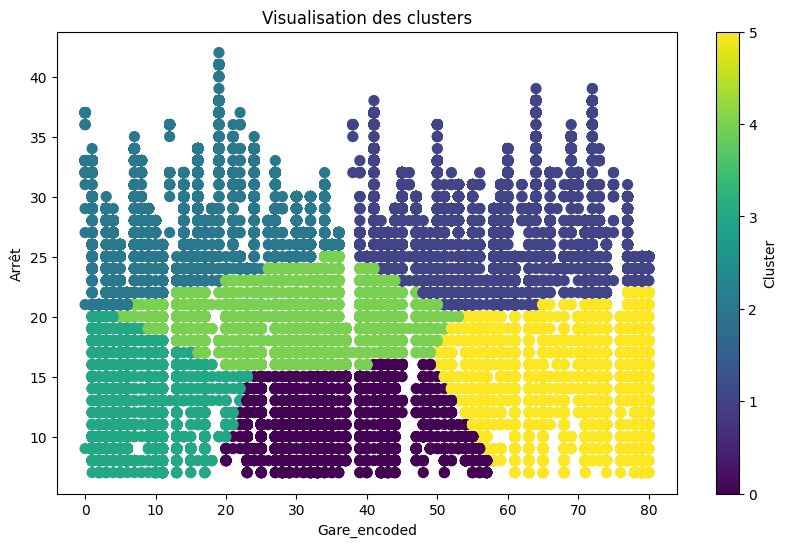

In [38]:
from sklearn.decomposition import PCA

# Réduction à 2 dimensions avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustering)

# Visualisation des clusters
plt.figure(figsize=(10, 6))
plt.scatter(dfTrain['gare_encoded'], dfTrain['arret'], c=dfTrain['Cluster_gare/arret'], cmap='viridis', s=50)
plt.title("Visualisation des clusters")
plt.xlabel("Gare_encoded")
plt.ylabel("Arrêt")
plt.colorbar(label="Cluster")
plt.show()

#### Clustering total

In [39]:
# Sélection des features totales
features_clustering = ['p0q2', 'p0q3', 'p0q4', 'p2q0', 'p3q0', 'p4q0', 'gare_encoded', 'arret']

# Standardisation des données pour le clustering
scaler3 = StandardScaler()
X_clustering = scaler3.fit_transform(dfTrain[features_clustering])

In [40]:
# # Déterminer le nombre optimal de clusters avec la méthode du coude
# inertia = []
# K_range = range(1, 20)

# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(X_clustering)
#     inertia.append(kmeans.inertia_)

# # Tracer la méthode du coude
# plt.figure(figsize=(10, 6))
# plt.plot(K_range, inertia, marker='o')
# plt.title("Méthode du coude")
# plt.xlabel("Nombre de clusters")
# plt.ylabel("Inertia")
# plt.grid(True)
# plt.show()


# # Trouver le "coude" automatiquement
# knee_locator = KneeLocator(K_range, inertia, curve="convex", direction="decreasing")
# optimal_k = knee_locator.knee
# print(f"Nombre optimal de clusters (méthode du coude automatique) : {optimal_k}")

# # Appliquer KMeans avec le nombre optimal de clusters 
# kmeans3 = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
# dfTrain['Cluster_tot'] = kmeans3.fit_predict(X_clustering)

# # Ajouter la même feature au jeu de test
# X_clustering_test = scaler3.transform(dfTest[features_clustering])
# dfTest['Cluster_tot'] = kmeans3.predict(X_clustering_test)

# # Vérification
# print(dfTrain[['Cluster_tot']].head())
# print(dfTest[['Cluster_tot']].head())

In [41]:
optimal_k = 7

# Appliquer KMeans avec le nombre optimal de clusters 
kmeans3 = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
dfTrain['Cluster_tot'] = kmeans3.fit_predict(X_clustering)

# Ajouter la même feature au jeu de test
X_clustering_test = scaler3.transform(dfTest[features_clustering])
dfTest['Cluster_tot'] = kmeans3.predict(X_clustering_test)

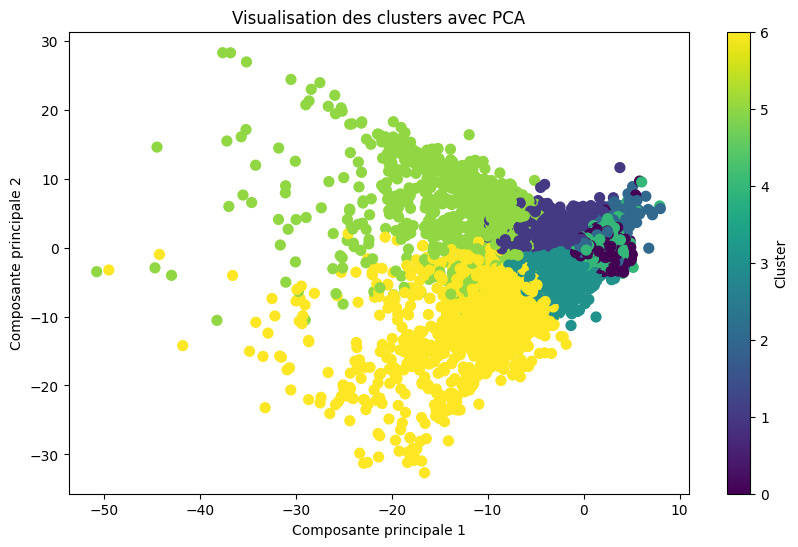

In [42]:
from sklearn.decomposition import PCA

# Réduction à 2 dimensions avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustering)

# Visualisation des clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dfTrain['Cluster_tot'], cmap='viridis', s=50)
plt.title("Visualisation des clusters avec PCA")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.colorbar(label="Cluster")
plt.show()

dfTrain = dfTrain.drop(columns=['gare_encoded'])
dfTest = dfTest.drop(columns=['gare_encoded'])



#### Conversion des dates + ajouts sinus , ....

In [43]:
#Conversion str en date + ajout jour sin , ...
dfTrain["date"] = pd.to_datetime(dfTrain["date"])
# print(dfTrain["date"].unique().size)


#Ajout jour
dfTrain["jour"] = dfTrain["date"].dt.weekday
dfTrain["mois"] = dfTrain["date"].dt.month
dfTrain["semaine_sin"] = np.sin(2 * np.pi * dfTrain['jour']/7.0)
dfTrain["date"].dt.day_of_year

    

dfTrain['jour_sin'] = np.sin(2 * np.pi * dfTrain['jour']/7.0)
dfTrain['jour_cos'] = np.cos(2 * np.pi * dfTrain['jour']/7.0)

dfTrain['mois_sin'] = np.sin(2 * np.pi * dfTrain['mois']/12.0)
dfTrain['mois_cos'] = np.cos(2 * np.pi * dfTrain['mois']/12.0)

#Ajout des semaine 

# Calcul de la première date
premiere_jour_annee = pd.to_datetime('2023-01-01')

# Nombre de jours écoulés
dfTrain["jours_annee"] =  dfTrain['date'].dt.dayofyear

# Nombre de semaines écoulées
dfTrain["semaines_ecoulees"] = (dfTrain["jours_annee"] / 7).astype(int)

# Encodage périodique pour les semaines
dfTrain['semaine_sin'] = np.sin(2 * np.pi * dfTrain['semaines_ecoulees'] / 52)
dfTrain['semaine_cos'] = np.cos(2 * np.pi * dfTrain['semaines_ecoulees'] / 52)

# print(dfTrain["jours_ecoules"].max())
# print( dfTrain['semaines_ecoulees'].min())

dfTrain.head()

#Conversion str en date pour test
dfTest["date"] = pd.to_datetime(dfTest["date"])



#Ajout jour
dfTest["jour"] = dfTest["date"].dt.weekday
dfTest["mois"] = dfTest["date"].dt.month

dfTest['jour_sin'] = np.sin(2 * np.pi * dfTest['jour']/7.0)
dfTest['jour_cos'] = np.cos(2 * np.pi * dfTest['jour']/7.0)

dfTest['mois_sin'] = np.sin(2 * np.pi * dfTest['mois']/12.0)
dfTest['mois_cos'] = np.cos(2 * np.pi * dfTest['mois']/12.0)

#Ajout semaine

# Nombre de jours écoulés
dfTest["jours_annee"] =  dfTest['date'].dt.dayofyear

# Nombre de semaines écoulées
dfTest["semaines_ecoulees"] = (dfTest["jours_annee"] / 7).astype(int)

# Encodage périodique pour les semaines
dfTest['semaine_sin'] = np.sin(2 * np.pi * dfTest['semaines_ecoulees'] / 52)
dfTest['semaine_cos'] = np.cos(2 * np.pi * dfTest['semaines_ecoulees'] / 52)

dfTrain = pd.get_dummies(dfTrain, columns=['jour'], drop_first=True)
dfTest = pd.get_dummies(dfTest, columns=['jour'], drop_first=True)


#### Nombre apparition de gare

    train gare       date  arret  p2q0  p3q0  p4q0  p0q2  p0q3  p0q4  ...  \
0  ZPQEKP  VXY 2023-11-13     12   0.0   0.0  -2.0  -4.0  -2.0  -4.0  ...   
1  KIQSRA  VXY 2023-11-13     12   0.0   0.0  -1.0   1.0  -1.0   0.0  ...   
2  QQJYYT  VXY 2023-11-13     12   0.0   1.0  -1.0   1.0  -1.0   1.0  ...   
3  FVKYMZ  VXY 2023-11-13     12   0.0   0.0  -1.0  -1.0   0.0  -1.0  ...   
4  GXNZBY  AZA 2023-11-13     12   1.0  -2.0   0.0   0.0   0.0   0.0  ...   

   mois_cos  jours_annee  semaines_ecoulees  semaine_sin  semaine_cos  jour_1  \
0  0.866025          317                 45    -0.748511     0.663123   False   
1  0.866025          317                 45    -0.748511     0.663123   False   
2  0.866025          317                 45    -0.748511     0.663123   False   
3  0.866025          317                 45    -0.748511     0.663123   False   
4  0.866025          317                 45    -0.748511     0.663123   False   

   jour_2  jour_3  jour_4  nb_apparitions_total_ga

<Axes: title={'center': 'Nombre de gare'}, xlabel='nb_apparitions_total_gare'>

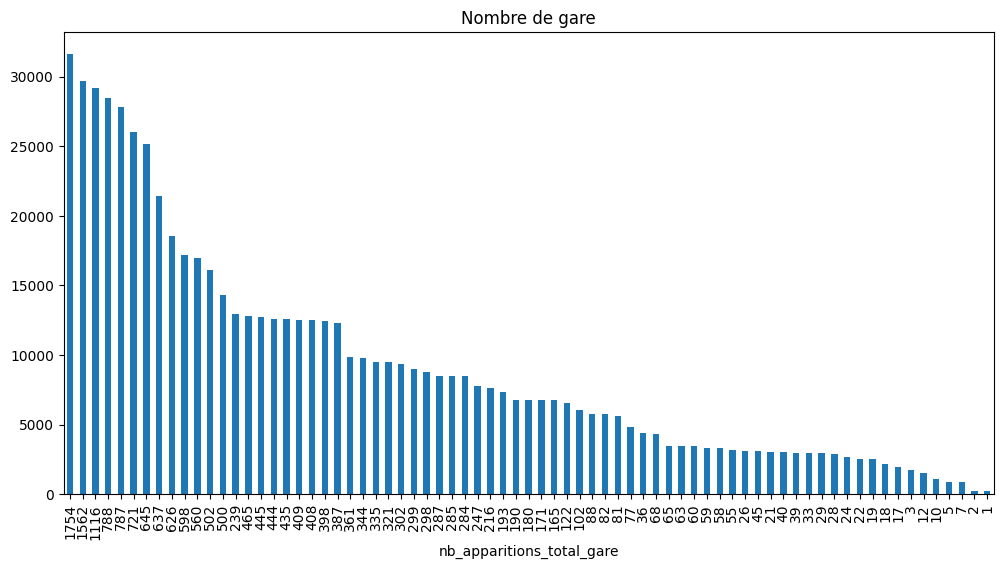

In [44]:
#Pour compter les apparitions des gare 
# Calculer le nombre total d'apparitions de chaque gare
gare_counts = dfTrain["gare"].value_counts()
# Ajouter cette information en tant que colonne dans le dataset
dfTrain["nb_apparitions_total_gare"] = dfTrain["gare"].map(gare_counts)
gare_day_counts = dfTrain.groupby(["gare", "date"])
print(gare_day_counts)

dfTrain['nb_apparitions_total_gare'].value_counts().plot(kind='bar', figsize=(12, 6), title="Nombre de gare")


#gare_day_counts = gare_day_counts.size().reset_index(name="counts")
#Pour rajouter une colonne avec le nombre d'apparitions de chaque gare par jour

gare_counts2 = dfTest["gare"].value_counts()
# Ajouter cette information en tant que colonne dans le dataset
dfTest["nb_apparitions_total_gare"] = dfTest["gare"].map(gare_counts2)

print(dfTest.head())
gare_day_counts2 = dfTest.groupby(["gare", "date"])
print(gare_day_counts2)

dfTest['nb_apparitions_total_gare'].value_counts().plot(kind='bar', figsize=(12, 6), title="Nombre de gare")




In [45]:

x1 = dfTrain['gare'].copy()
x2 = dfTest['gare'].copy()

dfTrain = pd.get_dummies(dfTrain, columns=['gare'])
dfTest = pd.get_dummies(dfTest, columns=['gare'])

dfTrain['gare'] = x1
dfTest['gare'] = x2


#### Retard moyen par gare en fonction du train précédent à la même gare 

In [46]:
## Retard moyen par gare

dfTrain_sorted = dfTrain.sort_values(by=["gare", "arret"])

# Regrouper les gares par gare pour faire les moyennes des retards de chaque gare
gare_retard = dfTrain_sorted.groupby("gare")["p2q0"].apply((lambda x: np.mean(x))).reset_index()
gare_retard.columns = ["gare", "p2q0_mean"]

# Mapper les moyennes des retards aux gares correspondantes dans dfTrain
dfTrain = dfTrain.merge(gare_retard, on="gare", how="left")
dfTrain.rename(columns={"p2q0_mean": "moyretard_gare"}, inplace=True)


#################


dfTest_sorted = dfTest.sort_values(by=["gare", "arret"])

# Regrouper les gares par gare pour faire les moyennes des retards de chaque gare
gare_retard = dfTest_sorted.groupby("gare")["p2q0"].apply((lambda x: np.mean(x))).reset_index()
gare_retard.columns = ["gare", "p2q0_mean"]

# Mapper les moyennes des retards aux gares correspondantes dans dfTrain
dfTest = dfTest.merge(gare_retard, on="gare", how="left")
dfTest.rename(columns={"p2q0_mean": "moyretard_gare"}, inplace=True)

#### Retard moyen par gare en fonction du même à la gare précédente

In [47]:
## Retard moyen par gare

dfTrain_sorted = dfTrain.sort_values(by=["gare", "arret"])

# Regrouper les gares par gare pour faire les moyennes des retards de chaque gare
gare_retard = dfTrain_sorted.groupby("gare")["p0q2"].apply((lambda x: np.mean(x))).reset_index()
gare_retard.columns = ["gare", "p0q2_mean"]

# Mapper les moyennes des retards aux gares correspondantes dans dfTrain
dfTrain = dfTrain.merge(gare_retard, on="gare", how="left")
dfTrain.rename(columns={"p0q2_mean": "moyretard_gare_gareprec"}, inplace=True)


#################


dfTest_sorted = dfTest.sort_values(by=["gare", "arret"])

# Regrouper les gares par gare pour faire les moyennes des retards de chaque gare
gare_retard = dfTest_sorted.groupby("gare")["p0q2"].apply((lambda x: np.mean(x))).reset_index()
gare_retard.columns = ["gare", "p0q2_mean"]

# Mapper les moyennes des retards aux gares correspondantes dans dfTrain
dfTest = dfTest.merge(gare_retard, on="gare", how="left")
dfTest.rename(columns={"p0q2_mean": "moyretard_gare_gareprec"}, inplace=True)

#### Retard moyen par jour / semaine / mois sans sin-cos

In [48]:
# ## Retard moyen par jour
# jour_retard = dfTrain_sorted.groupby("date")["p0q2"].apply((lambda x: np.mean(x))).reset_index()
# jour_retard.columns = ["date", "p0q2_mean"]

# # Mapper les moyennes des retards aux gares correspondantes dans dfTrain
# dfTrain = dfTrain.merge(jour_retard, on="date", how="left")
# dfTrain.rename(columns={"p0q2_mean": "moyretard_jour"}, inplace=True)


# # Regrouper les gares par gare pour faire les moyennes des retards de chaque gare
# jour_retard = dfTest_sorted.groupby("date")["p0q2"].apply((lambda x: np.mean(x))).reset_index()
# jour_retard.columns = ["date", "p0q2_mean"]

# # Mapper les moyennes des retards aux gares correspondantes dans dfTrain
# dfTest = dfTest.merge(jour_retard, on="date", how="left")
# dfTest.rename(columns={"p0q2_mean": "moyretard_jour"}, inplace=True)


# #################

# #Retard moyen par semaine 
# semaine_retard = dfTrain_sorted.groupby("semaines_ecoulees")["p0q2"].apply((lambda x: np.mean(x))).reset_index()
# semaine_retard.columns = ["semaines_ecoulees", "p0q2_mean"]

# # Mapper les moyennes des retards aux gares correspondantes dans dfTrain
# dfTrain = dfTrain.merge(semaine_retard, on="semaines_ecoulees", how="left")
# dfTrain.rename(columns={"p0q2_mean": "moyretard_semaine"}, inplace=True)

# # Regrouper les gares par gare pour faire les moyennes des retards de chaque gare
# semaine_retard = dfTest_sorted.groupby("semaines_ecoulees")["p0q2"].apply((lambda x: np.mean(x))).reset_index()
# semaine_retard.columns = ["semaines_ecoulees", "p0q2_mean"]

# # Mapper les moyennes des retards aux gares correspondantes dans dfTrain
# dfTest = dfTest.merge(semaine_retard, on="semaines_ecoulees", how="left")
# dfTest.rename(columns={"p0q2_mean": "moyretard_semaine"}, inplace=True)


# #################

# #Retard moyen par mois
# mois_retard = dfTrain_sorted.groupby("mois")["p0q2"].apply((lambda x: np.mean(x))).reset_index()
# mois_retard.columns = ["mois", "p0q2_mean"]

# # Mapper les moyennes des retards aux gares correspondantes dans dfTrain
# dfTrain = dfTrain.merge(mois_retard, on="mois", how="left")
# dfTrain.rename(columns={"p0q2_mean": "moyretard_mois"}, inplace=True)

# # Regrouper les gares par gare pour faire les moyennes des retards de chaque gare
# mois_retard = dfTest_sorted.groupby("mois")["p0q2"].apply((lambda x: np.mean(x))).reset_index()
# mois_retard.columns = ["mois", "p0q2_mean"]

# # Mapper les moyennes des retards aux gares correspondantes dans dfTrain
# dfTest = dfTest.merge(mois_retard, on="mois", how="left")
# dfTest.rename(columns={"p0q2_mean": "moyretard_mois"}, inplace=True)


#### Retard moyen par jour / semaine / mois avec sin-cos

In [49]:
## Retard moyen par jour
# Moyenne des retards par jour avec sin et cos
jour_retard = dfTrain.groupby(["jour_sin", "jour_cos"])["p0q2"].mean().reset_index()
jour_retard.columns = ["jour_sin", "jour_cos", "moyretard_jour"]

# Fusion avec dfTrain
dfTrain = dfTrain.merge(jour_retard, on=["jour_sin", "jour_cos"], how="left")

# Même chose pour dfTest
jour_retard_test = dfTest.groupby(["jour_sin", "jour_cos"])["p0q2"].mean().reset_index()
jour_retard_test.columns = ["jour_sin", "jour_cos", "moyretard_jour"]
dfTest = dfTest.merge(jour_retard_test, on=["jour_sin", "jour_cos"], how="left")


#################

#Retard moyen par semaine 

# Moyenne des retards par mois avec sin et cos
semaine_retard = dfTrain.groupby(["semaine_sin", "semaine_cos"])["p0q2"].mean().reset_index()
semaine_retard.columns = ["semaine_sin", "semaine_cos", "moyretard_semaine"]

# Fusion avec dfTrain
dfTrain = dfTrain.merge(semaine_retard, on=["semaine_sin", "semaine_cos"], how="left")

# Même chose pour dfTest
semaine_retard = dfTest.groupby(["semaine_sin", "semaine_cos"])["p0q2"].mean().reset_index()
semaine_retard.columns = ["semaine_sin", "semaine_cos", "moyretard_semaine"]
dfTest = dfTest.merge(semaine_retard, on=["semaine_sin", "semaine_cos"], how="left")



#################

#Retard moyen par mois

# Moyenne des retards par mois avec sin et cos
mois_retard = dfTrain.groupby(["mois_sin", "mois_cos"])["p0q2"].mean().reset_index()
mois_retard.columns = ["mois_sin", "mois_cos", "moyretard_mois"]

# Fusion avec dfTrain
dfTrain = dfTrain.merge(mois_retard, on=["mois_sin", "mois_cos"], how="left")

# Même chose pour dfTest
mois_retard_test = dfTest.groupby(["mois_sin", "mois_cos"])["p0q2"].mean().reset_index()
mois_retard_test.columns = ["mois_sin", "mois_cos", "moyretard_mois"]
dfTest = dfTest.merge(mois_retard_test, on=["mois_sin", "mois_cos"], how="left")



#### Catégorie fréquence gare + Niveau arrêt + Type de retard

In [50]:
dfTrain['Frequence_gare'] = pd.cut(dfTrain['nb_apparitions_total_gare'], bins=[0,1000,5000,12000,17000,40000], labels=["Très Peu fréquentée", "Peu fréquentée", "Normal"," Fréquentée","Très fréquentée"])	   
dfTest['Frequence_gare'] = pd.cut(dfTest['nb_apparitions_total_gare'], bins=[0,1000,5000,12000,17000,40000], labels=["Très Peu fréquentée", "Peu fréquentée", "Normal"," Fréquentée","Très fréquentée"])	   


dfTrain['Niveau_arret'] = pd.cut(dfTrain['arret'], bins=[1,15,24,33,42], labels=["Début de ligne", "Milieu/début de ligne"," Milieu/fin de ligne","Fin de ligne"])	   
dfTest['Niveau_arret'] = pd.cut(dfTest['arret'], bins=[1,15,24,33,42], labels=["Début de ligne", "Milieu/début de ligne"," Milieu/fin de ligne","Fin de ligne"])	   

#dfTrain['Frequence_arrêt'] = pd.cut(dfTrain['nb_apparitions_total_arret'], bins=[0,2000,10000,23000,27000], labels=["Très Peu fréquentée", "Peu fréquentée"," Fréquentée","Très fréquentée"])	   
#dfTrain['Frequence_arrêt'] = pd.cut(dfTrain['nb_apparitions_total_arret'], bins=[0,2000,10000,23000,27000], labels=["Très Peu fréquentée", "Peu fréquentée"," Fréquentée","Très fréquentée"])	   

# dfTrain['Niveau_arret'].value_counts().plot(kind='bar', figsize=(12, 6), title="Fréquence des gares")
#dfTrain['Frequence_arrêt'].value_counts().plot(kind='bar', figsize=(12, 6), title="Fréquence des arrêts")

# dfTrain['Type_retard'] = pd.cut(dfTrain['p0q2'], bins=[10,0,-5,-15,-200], labels=["En avance", "un peu en retard", "Retard"," Gros retard"])	   

#### Groupement des arrêts par densité 

In [51]:
# arret_counts = dfTrain["arret"].value_counts()
# # Ajouter cette information en tant que colonne dans le dataset
# dfTrain["nb_apparitions_total_arret"] = dfTrain["arret"].map(arret_counts)

#### Tendance des retards

In [52]:
dfTrain["Diff_p0q2_p0q3"] = dfTrain["p0q3"] - dfTrain["p0q2"]
dfTrain["Diff_p0q3_p0q4"] = dfTrain["p0q4"] - dfTrain["p0q3"]

dfTrain["Diff_p2q0_p3q0"] = dfTrain["p3q0"] - dfTrain["p2q0"]
dfTrain["Diff_p3q0_p4q0"] = dfTrain["p4q0"] - dfTrain["p0q3"]


dfTest["Diff_p0q2_p0q3"] = dfTest["p0q3"] - dfTest["p0q2"]
dfTest["Diff_p0q3_p0q4"] = dfTest["p0q4"] - dfTest["p0q3"]

dfTest["Diff_p2q0_p3q0"] = dfTest["p3q0"] - dfTest["p2q0"]
dfTest["Diff_p3q0_p4q0"] = dfTest["p4q0"] - dfTest["p0q3"]



# dfTrain["Diff_p0q2_p0q4"] = dfTrain["p0q4"] - dfTrain["p0q2"]
# dfTrain["Diff_p2q0_p4q0"] = dfTrain["p4q0"] - dfTrain["p2q0"]

# dfTest["Diff_p0q2_p0q4"] = dfTest["p0q4"] - dfTest["p0q4"]
# dfTest["Diff_p2q0_p4q0"] = dfTest["p4q0"] - dfTest["p4q0"]



#### Tendance de la tendance (gradient)

In [53]:
dfTrain["Tendance_retard_gare"] = dfTrain["Diff_p3q0_p4q0"] - dfTrain["Diff_p2q0_p3q0"]
dfTrain["Tendance_retard_train"] = dfTrain["Diff_p0q3_p0q4"] - dfTrain["Diff_p0q2_p0q3"]

dfTest["Tendance_retard_gare"] = dfTest["Diff_p3q0_p4q0"] - dfTest["Diff_p2q0_p3q0"]
dfTest["Tendance_retard_train"] = dfTest["Diff_p0q3_p0q4"] - dfTest["Diff_p0q2_p0q3"]


dfTrain = dfTrain.drop(columns = ['Diff_p3q0_p4q0','Diff_p0q3_p0q4'])
dfTest = dfTest.drop(columns = ['Diff_p3q0_p4q0','Diff_p0q3_p0q4'])

#### Tri des trajets par voies

In [54]:
# # Trier les données par voies
# dfTrain_sorted = dfTrain.sort_values(by=["train", "arret"])

# # Regrouper les gares par train pour former les trajets
# train_routes = dfTrain_sorted.groupby("train")["gare"].apply(tuple).reset_index()

# # Compter les occurrences des trajets (listes de gares)
# route_counts = train_routes["gare"].value_counts().reset_index()
# route_counts.columns = ["Trajet", "Occurrences"]

    
# # Associer chaque trajet à ses trains uniques
# trajet_trains = train_routes.groupby("gare")["train"].apply(set).reset_index()

# # Renommer les colonnes pour correspondre à route_counts
# trajet_trains.columns = ["Trajet", "Trains"]

# # Fusionner avec route_counts pour ajouter la colonne 'Trains'
# route_counts = route_counts.merge(trajet_trains, on="Trajet", how="left")

# # Afficher le résultat
# # route_counts.head()

# # Trier les trajets du plus long au plus court
# route_counts["Trajet_length"] = route_counts["Trajet"].apply(len)
# route_counts = route_counts.sort_values(by="Trajet_length", ascending=False).drop(columns=["Trajet_length"])


# # Dictionnaire pour stocker les trajets uniques et leurs occurrences mises à jour
# Trajets_existants = {}
# Correspondance_voies ={}


# from Levenshtein import distance as levenshtein_distance

# # Fonction pour vérifier si deux trajets sont similaires
# def are_similar(trajet1, trajet2,alpha=0.1):
#     tolerance = max(1, int(alpha * max(len(trajet1), len(trajet2))))
#     return levenshtein_distance(trajet1, trajet2) <= tolerance


# # Vérifier si un trajet est contenu dans un plus grand trajet et fusionner les occurrences
# for trajet, occurrences,train_set in zip(route_counts["Trajet"], route_counts["Occurrences"],route_counts["Trains"]):
#     added_to_existing = False
#     for large_trajet in Trajets_existants:

#         if set(trajet).issubset(set(large_trajet)) or are_similar(trajet, large_trajet):  # Vérifie si trajet est une sous-séquence
#             # Si oui, on ajoute les occurrences du trajet actuel au trajet représentatif
#             Trajets_existants[large_trajet] += occurrences
#             added_to_existing = True
#             # Mettre à jour la correspondance pour chacun des trains dans l'ensemble
#             for t in train_set:
#                 Correspondance_voies[t] = large_trajet
#             break  # On sort de la boucle dès qu'un match est trouvé

#     if not added_to_existing:
#         Trajets_existants[trajet] = occurrences
#         # final_trajets.append(trajet)
#         for t in train_set:
#             Correspondance_voies[t] = trajet


# # Construire le DataFrame final avec les occurrences mises à jour
# final_routes_df = pd.DataFrame({"Trajet": list(Trajets_existants.keys()), "Occurrences": list(Trajets_existants.values())})
# final_routes_df.sort_values('Occurrences', ascending=False, inplace=True)

# # Afficher les trajets principaux
# # (final_routes_df.head())
# route_counts.head()
# # Correspondance_voies

# print(final_routes_df.size)

# dfTrain["Voie_num"] = dfTrain["train"].map(Correspondance_voies).astype("category").cat.codes.astype("category")



# print(dfTrain['Voie_num'])

In [55]:
# # Trier les données par voies
# dfTest_sorted = dfTest.sort_values(by=["train", "arret"])

# # Regrouper les gares par train pour former les trajets
# train_routes = dfTest.groupby("train")["gare"].apply(tuple).reset_index()

# # Compter les occurrences des trajets (listes de gares)
# route_counts = train_routes["gare"].value_counts().reset_index()
# route_counts.columns = ["Trajet", "Occurrences"]

    
# # Associer chaque trajet à ses trains uniques
# trajet_trains = train_routes.groupby("gare")["train"].apply(set).reset_index()

# # Renommer les colonnes pour correspondre à route_counts
# trajet_trains.columns = ["Trajet", "Trains"]

# # Fusionner avec route_counts pour ajouter la colonne 'Trains'
# route_counts = route_counts.merge(trajet_trains, on="Trajet", how="left")

# # Afficher le résultat
# # route_counts.head()

# # Trier les trajets du plus long au plus court
# route_counts["Trajet_length"] = route_counts["Trajet"].apply(len)
# route_counts = route_counts.sort_values(by="Trajet_length", ascending=False).drop(columns=["Trajet_length"])


# # Dictionnaire pour stocker les trajets uniques et leurs occurrences mises à jour
# Trajets_existants = {}
# Correspondance_voies ={}


# from Levenshtein import distance as levenshtein_distance

# # Fonction pour vérifier si deux trajets sont similaires
# def are_similar(trajet1, trajet2,alpha=0.1):
#     tolerance = max(1, int(alpha * max(len(trajet1), len(trajet2))))
#     return levenshtein_distance(trajet1, trajet2) <= tolerance


# # Vérifier si un trajet est contenu dans un plus grand trajet et fusionner les occurrences
# for trajet, occurrences,train_set in zip(route_counts["Trajet"], route_counts["Occurrences"],route_counts["Trains"]):
#     added_to_existing = False
#     for large_trajet in Trajets_existants:

#         if set(trajet).issubset(set(large_trajet)) or are_similar(trajet, large_trajet):  # Vérifie si trajet est une sous-séquence
#             # Si oui, on ajoute les occurrences du trajet actuel au trajet représentatif
#             Trajets_existants[large_trajet] += occurrences
#             added_to_existing = True
#             # Mettre à jour la correspondance pour chacun des trains dans l'ensemble
#             for t in train_set:
#                 Correspondance_voies[t] = large_trajet
#             break  # On sort de la boucle dès qu'un match est trouvé

#     if not added_to_existing:
#         Trajets_existants[trajet] = occurrences
#         # final_trajets.append(trajet)
#         for t in train_set:
#             Correspondance_voies[t] = trajet


# # Construire le DataFrame final avec les occurrences mises à jour
# final_routes_df = pd.DataFrame({"Trajet": list(Trajets_existants.keys()), "Occurrences": list(Trajets_existants.values())})
# final_routes_df.sort_values('Occurrences', ascending=False, inplace=True)

# # Afficher les trajets principaux
# # (final_routes_df.head())
# route_counts.head()
# # Correspondance_voies

# print(final_routes_df.size)

# dfTest["Voie_num"] = dfTest["train"].map(Correspondance_voies).astype("category")


# print(dfTest.groupby('Voie_num').size)

In [56]:
# Jour de la semaine d'une autre manière avec get dumies 

# dfTrain["jour_semaine"] = dfTrain["date"].dt.strftime("%A")
# encodertestjour = pd.get_dummies(dfTrain['jour_semaine'], columns='jour_semaine')
# dfTrain = pd.concat([dfTrain.drop(columns='jour_semaine'), encodertestjour], axis=1)
# dfTrain.head()

# dfTest["jour_semaine"] = dfTest["date"].dt.strftime("%A")
# encodertest = pd.get_dummies(dfTest['jour_semaine'], columns='jour_semaine')
# dfTest = pd.concat([dfTest.drop(columns='jour_semaine'), encodertest], axis=1)

In [57]:
# Ajouts ignorés


# dfTrain['WE'] = dfTrain['jour'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
#Il n'y a pas de Week end dans le train donc pas utile

# Ajouter les jours fériés en France 
#pas utile car notre modèle se passe après et ne le saura pas 
#fr_holidays = holidays.France(years=2023)
#dfTrain["ferie"] = dfTrain["date"].apply(lambda x: x in fr_holidays)

#Ajouter les vacances scolaires (Zone C en France)
# vacances_zone_c = [
#     ("2023-02-18", "2023-03-06"),  # Vacances d'hiver de PAris
#     ("2023-04-22", "2023-05-09"),  # Vacances de printemps
#     ("2023-07-08", "2023-09-03"),  # Vacances d'été
#     ("2023-10-21", "2023-11-05"),  # Vacances de la Toussaint
#     ("2023-12-23", "2024-01-07"),  # Vacances de Noël
# ]

# def est_vacances(date, vacances):
#     for debut, fin in vacances:
#         if debut <= date.strftime("%Y-%m-%d") <= fin:
#             return True
#     return False

# # Fonction pour identifier si une date est le premier jour de vacances
# def debut_vacances(date, vacances):
#     for debut, _ in vacances:
#         if date == debut:
#             return True
#     return False

# dfTrain["debut_vacances"] = dfTrain["date"].apply(lambda x: debut_vacances(x, vacances_zone_c))

# dfTrain["vacances"] = dfTrain["date"].apply(lambda x: est_vacances(x, vacances_zone_c))



### Découpage des données, si besoin

In [58]:

# Sélectionner toutes les colonnes sauf celles spécifiées
colonnes_a_exclure = [ 'gare','date', 'train', 'mois', 'jours_annee', 'semaines_ecoulees', 'semaine_sin', 'semaine_cos', 
                      'Frequence_gare', 'Niveau_arret', 'moyretard_gare_gareprec', 
                      'moyretard_semaine', 'Tendance_retard_train', 
                      'moyretard_mois', 'Diff_p0q2_p0q3', 'Diff_p2q0_p3q0', 'Tendance_retard_gare', 'Cluster_retard', 'Cluster_gare/arret', 'Cluster_tot', 'nb_apparitions_total_gare','train_frequency','moyretard_gare', 'moyretard_jour','gare_encoded']

dfTrainF = dfTrain[[col for col in dfTrain.columns if col not in colonnes_a_exclure]]
dfTestF = dfTest[[col for col in dfTest.columns if col not in colonnes_a_exclure]]

print(dfTrainF.columns)

Index(['arret', 'p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4', 'retard',
       'jour_sin', 'jour_cos', 'mois_sin', 'mois_cos', 'jour_1', 'jour_2',
       'jour_3', 'jour_4', 'gare_ADU', 'gare_ARX', 'gare_AUW', 'gare_AVF',
       'gare_AVU', 'gare_AZA', 'gare_BAP', 'gare_CFK', 'gare_DCD', 'gare_DGG',
       'gare_EAU', 'gare_ELZ', 'gare_EME', 'gare_EOH', 'gare_FDV', 'gare_FFU',
       'gare_GDN', 'gare_GDU', 'gare_GHQ', 'gare_GHU', 'gare_HVA', 'gare_IEG',
       'gare_JAQ', 'gare_JBZ', 'gare_JEQ', 'gare_JLR', 'gare_JOD', 'gare_JUJ',
       'gare_JYH', 'gare_KCK', 'gare_KDN', 'gare_KLN', 'gare_KOG', 'gare_KYF',
       'gare_LNI', 'gare_LXX', 'gare_MRI', 'gare_MZE', 'gare_NIJ', 'gare_NPF',
       'gare_NZC', 'gare_OCA', 'gare_OCB', 'gare_OJA', 'gare_OML', 'gare_OWI',
       'gare_PDG', 'gare_PLF', 'gare_PLR', 'gare_QDF', 'gare_QHI', 'gare_QYY',
       'gare_RAN', 'gare_RDN', 'gare_RDU', 'gare_RLW', 'gare_RSZ', 'gare_RUP',
       'gare_TRE', 'gare_TVD', 'gare_TXP', 'gare_UAK', 'gare_UPZ'

#### Différents Get dumies ( avant les splits)

In [59]:
# Ici sans induire d'ordre 

# x1 = dfTrainF['gare'].copy()
# x2 = dfTestF['gare'].copy()

# dfTrainF = pd.get_dummies(dfTrainF, columns=['gare'])
# dfTestF = pd.get_dummies(dfTestF, columns=['gare'])


## Encodage avec get dumies des jours

# dfTrainF = pd.get_dummies(dfTrainF, columns=['jour'], drop_first=True)
# dfTestF = pd.get_dummies(dfTestF, columns=['jour'], drop_first=True)

# Get dumies pour les clusters

# dfTrain = pd.get_dummies(dfTrain, columns=['Cluster_tot'], drop_first=True)
# dfTest = pd.get_dummies(dfTest, columns=['Cluster_tot'], drop_first=True) 

# dfTrain = pd.get_dummies(dfTrain, columns=['Cluster_gare/arret'], drop_first=True)
# dfTest = pd.get_dummies(dfTest, columns=['Cluster_gare/arret'], drop_first=True) 

# dfTrain = pd.get_dummies(dfTrain, columns=['Cluster_retard'], drop_first=True)
# dfTest = pd.get_dummies(dfTest, columns=['Cluster_retard'], drop_first=True) 

## Split avec jeu de train et test

In [60]:
# Avec les bons noms

y = dfTrainF["retard"]  # Target
X = dfTrainF.drop(columns=['retard'], axis=1)

x_train_transform = X
x_test_transform = dfTestF
y_train_transform = (y.values.reshape(-1, 1)).flatten()  # On normalise et on remet en 1D


In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_train_transform, y_train_transform, test_size=0.25, random_state=4)


#### Vérification des corrélations avant prédiction

In [62]:
# # Vérifier la corrélation
# correlation_retard_jour = dfTrainF['moyretard_jour'].corr(y_train)
# correlation_retard_gare = dfTrainF['moyretard_gare'].corr(y_train)

# correlation_arret= dfTrainF['arret'].corr(y_train)
# correlation_jour_sin = dfTrainF['jour_sin'].corr(y_train)


# print(f"Corrélation entre retard par jour et la cible : {correlation_retard_jour}")
# print(f"Corrélation entre retard par gare et la cible : {correlation_retard_gare}")
# print(f"Corrélation entre l'arret et la cible : {correlation_arret}")
# print(f"Corrélation entre le jour sin et la cible : {correlation_jour_sin}")

In [63]:
# # Vérifier la corrélation entre les nouvelles colonnes et les autres features
# correlation_matrix = dfTrainF[[ 'arret', 'p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4',
#        'retard', 'jour_sin', 'jour_cos', 'mois_sin', 'mois_cos', 'jour_1',
#        'jour_2', 'jour_3', 'jour_4', 'moyretard_gare', 'moyretard_jour']].corr()
# print(correlation_matrix)


## Encodage 

#### Encodage numérique

In [64]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler	   

# mm = MinMaxScaler()
# st=StandardScaler()

# num_features = X.select_dtypes(np.number).columns.drop(["Voie_num", "Niveau_arret","Frequence_gare"], errors='ignore')
# print(num_features)


# st.fit(X_train[num_features])
# X_train[num_features] = st.transform(X_train[num_features])
# X_test[num_features] = st.transform(X_test[num_features])
# x_test_transform[num_features] = st.transform(x_test_transform[num_features])

# # y_train_transform = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()  # On normalise et on remet en 1D

# # Normalisation de la cible (y_train)
# st_y = StandardScaler()
# y_train = y_train.reshape(-1, 1)  # Reshape en 2D
# y_test = y_test.reshape(-1, 1)  # Reshape en 2D

# # st_y.fit(y_train)  # Ajustement sur y_train
# # y_train = st_y.transform(y_train).flatten()  # On remet en 1D après la transformation
# # y_test_transform = st_y.transform(y_test).flatten()
# print(X_train.dtypes)


#### Encodage catégorielle 

In [65]:
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# import category_encoders as ce

# # Initialisation des encodeurs
# fe = ce.CountEncoder()
# le = LabelEncoder()
# scaler = MinMaxScaler()

# # Encodage FrequencyEncoder pour 'Frequence_gare'
# fe.fit(X_train['Frequence_gare'])
# X_train['Frequence_gare'] = fe.transform(X_train['Frequence_gare'])
# X_test['Frequence_gare'] = fe.transform(X_test['Frequence_gare'])
# x_test_transform['Frequence_gare'] = fe.transform(x_test_transform['Frequence_gare'])

# # Normalisation entre 0 et 1 avec MinMaxScaler
# scaler.fit(X_train[['Frequence_gare']])
# X_train['Frequence_gare'] = scaler.transform(X_train[['Frequence_gare']])
# X_test['Frequence_gare'] = scaler.transform(X_test[['Frequence_gare']])
# x_test_transform['Frequence_gare'] = scaler.transform(x_test_transform[['Frequence_gare']])


# # # Encodage FrequencyEncoder pour 'Voie_num'
# # fe.fit(X_train['Voie_num'])
# # X_train['Voie_num'] = fe.transform(X_train['Voie_num'])
# # X_test['Voie_num'] = fe.transform(X_test['Voie_num'])
# # x_test_transform['Voie_num'] = fe.transform(x_test_transform['Voie_num'])

# # # Normalisation entre 0 et 1 avec MinMaxScaler
# # scaler.fit(X_train[['Voie_num']])
# # X_train['Voie_num'] = scaler.transform(X_train[['Voie_num']])
# # X_test['Voie_num'] = scaler.transform(X_test[['Voie_num']])
# # x_test_transform['Voie_num'] = scaler.transform(x_test_transform[['Voie_num']])


# # Encodage LabelEncoder pour 'Niveau_arret'
# le.fit(X_train[['Niveau_arret']])
# X_train['Niveau_arret'] = le.transform(X_train['Niveau_arret'])
# X_test['Niveau_arret'] = le.transform(X_test['Niveau_arret'])
# x_test_transform['Niveau_arret'] = le.transform(x_test_transform['Niveau_arret'])

# # Normalisation entre 0 et 1 avec MinMaxScaler
# scaler.fit(X_train[['Niveau_arret']])
# X_train['Niveau_arret'] = scaler.transform(X_train[['Niveau_arret']])
# X_test['Niveau_arret'] = scaler.transform(X_test[['Niveau_arret']])
# x_test_transform['Niveau_arret'] = scaler.transform(x_test_transform[['Niveau_arret']])


# x_test_transform.head()


In [66]:
#Encodage précédent
# ct_exemple = make_column_transformer(
#       (StandardScaler(),
#        make_column_selector(dtype_include=np.number)),  
#       (OneHotEncoder(),
#        make_column_selector(dtype_include=object)))  


# ct_exemple.fit(X) 
# x_train_transform = ct_exemple.transform(X)
# x_test_transform = ct_exemple.transform(dfTest)


# scaler_y = StandardScaler()
# y_train_transform = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()  # On normalise et on remet en 1D
# # #pd.DataFrame(x_train_transform).head()
# # y_train_transform = y.to_numpy()

# print(x_train_transform)

## Comparaison des modèles 

In [67]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.svm import SVR
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import mean_absolute_error, r2_score


# # Initialisation des modèles
# linear_regression = LinearRegression(n_jobs=-1)
# random_forest = RandomForestRegressor(
#     n_estimators=50,       # Réduit le nombre d'arbres
#     max_depth=10,          # Limite la profondeur des arbres
#     n_jobs=-1,             # Utilise tous les cœurs du processeur
#     random_state=42        # Assure la reproductibilité
# )
# knn = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
# xgboost = XGBRegressor(random_state=42,n_jobs=-1)

# # Entraînement et prédiction pour chaque modèle
# # Linear Regression
# linear_regression.fit(X_train, y_train)
# y_pred_lr = linear_regression.predict(X_test)
# mae_lr = mean_absolute_error(y_test, y_pred_lr)
# r2_lr = r2_score(y_test, y_pred_lr)

# # Random Forest
# random_forest.fit(X_train, y_train)
# y_pred_rf = random_forest.predict(X_test)
# mae_rf = mean_absolute_error(y_test, y_pred_rf)
# r2_rf = r2_score(y_test, y_pred_rf)

# # K-Nearest Neighbors
# knn.fit(X_train, y_train)
# y_pred_knn = knn.predict(X_test)
# mae_knn = mean_absolute_error(y_test, y_pred_knn)
# r2_knn = r2_score(y_test, y_pred_knn)

# # XGBoost
# xgboost.fit(X_train, y_train)
# y_pred_xgb = xgboost.predict(X_test)
# mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
# r2_xgb = r2_score(y_test, y_pred_xgb)

# # Comparaison des résultats
# results = {
#     "Linear Regression": {"MAE": mae_lr, "R²": r2_lr},
#     "Random Forest": {"MAE": mae_rf, "R²": r2_rf},
#     "K-Nearest Neighbors": {"MAE": mae_knn, "R²": r2_knn},
#     "XGBoost": {"MAE": mae_xgb, "R²": r2_xgb}
# }

# # Affichage des résultats
# print("Comparaison des modèles :")
# for name, metrics in results.items():
#     print(f"{name}: MAE = {metrics['MAE']:.4f}")

# # Identifier le meilleur modèle
# best_model = min(results, key=lambda x: results[x]["MAE"])
# print(f"\nLe meilleur modèle est : {best_model} avec un MAE de {results[best_model]['MAE']:.4f}")

Nous décidons de prendre XGBOOST en raison de valeurs de MEA relativement égales et une vitesse de calcul bien plus rapide

## Prédiction avec XGBOOST

### Mise en place de la validation 

In [68]:
from sklearn.model_selection import KFold,TimeSeriesSplit

# Définition de la validation croisée avec KFold (jeux de données équilibrés)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
tscv = TimeSeriesSplit(n_splits=3)


In [69]:
from xgboost import XGBRegressor
from sklearn.metrics import  mean_absolute_error

xgb = XGBRegressor(alpha=0.1, reg_lambda=0.1, random_state=42)
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
mae_xgboost = mean_absolute_error(y_test,y_pred1)

print("Mean Absolute Error XGBoost sans hyperparamètre et sans validation croisée :", mae_xgboost)

Mean Absolute Error XGBoost sans hyperparamètre et sans validation croisée : 0.7322586323206974


#### Evaluation sans hyperparamètre et avec la validation croisée

In [70]:
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import mean_absolute_error
import numpy as np

# Initialiser XGBRegressor avec les paramètres par défaut
xgb = XGBRegressor(alpha=0.1, reg_lambda=0.1, random_state=4)


# Évaluer le modèle avec MAE
scores = cross_val_score(xgb, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')

# Afficher les résultats
print(f'Scores MAE pour chaque fold: {-scores}')
print(f'Moyenne des scores MAE: {-np.mean(scores):.4f}')

Scores MAE pour chaque fold: [0.75668478 0.74219183 0.74247231]
Moyenne des scores MAE: 0.7471


#### Evaluation avec les hyperparamètres avec validation croisée intégré dans grid search

In [82]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model_xgb = XGBRegressor()

# Paramètres à tester pour le réglage des hyperparamètres
param_grid = {
    'alpha':[0.05, 0.5],
    'reg_lambda':[0.8, 1.1],
    'n_estimators': [150, 200, 250],  # Nombre d'arbres
    'max_depth': [6, 10],      # Profondeur des arbres
    'learning_rate': [0.05, 0.1, 0.2], # Taux d'apprentissage
    'subsample': [0.65, 0.9],      # Sous-échantillonnage des données
    'colsample_bytree': [0.8, 0.9] # Sous-échantillonnage des features
}

# # Paramètres à tester pour le réglage des hyperparamètres de fion 
# param_grid = {
#     'alpha':[0.1, 1],
#     'reg_lambda':[0.1, 1],
#     'n_estimators': [100, 200],  # Nombre d'arbres
#     'max_depth': [3, 9],      # Profondeur des arbres
#     'learning_rate': [0.01, 0.1], # Taux d'apprentissage
#     'subsample': [0.8, 1.0],      # Sous-échantillonnage des données
#     'colsample_bytree': [0.8, 1.0] # Sous-échantillonnage des features
# }

# param_distributions = {
#     'alpha':uniform(0.1, 1),
#     'reg_lambda':uniform(0.1, 1),
#     'learning_rate': uniform(0.01, 0.3),  # Distribution uniforme entre 0.01 et 0.3
#     'max_depth': randint(3, 10),  # Entier aléatoire entre 3 et 10
#     'min_child_weight': randint(1, 6),  # Entier entre 1 et 5
#     'gamma': uniform(0, 5),  # Distribution entre 0 et 5
#     'n_estimators': randint(50, 700),  # Nombre d'estimateurs entre 50 et 700
#     'colsample_bytree': uniform(0.1, 0.2)  # Entre 0.1 et 0.3
# }


# Grid Search avec validation croisée et optimisation de MAE
grid_search = GridSearchCV(
    estimator=model_xgb, 
    param_grid=param_grid, 
    cv=tscv, 
    scoring='neg_mean_absolute_error',  # Optimisation de MAE
    verbose=2,
    n_jobs=-1
)

# Utiliser RandomizedSearchCV pour chercher les meilleurs hyperparamètres
random_search = RandomizedSearchCV( xgb, param_grid, n_iter=20, scoring='neg_mean_absolute_error', cv=kfold, verbose=1, n_jobs=-1, random_state=42)

# Entraîner la recherche d'hyperparamètres
random_search.fit(X, y)

xgb_optimized=random_search.best_estimator_

# Afficher les meilleurs paramètres
print("Meilleurs hyperparamètres :", random_search.best_params_)
print("Meilleur score MAE :", -random_search.best_score_)

# # Lancer la recherche
# grid_search.fit(X, y)

# # Afficher les meilleurs paramètres
# print("Meilleurs hyperparamètres :", grid_search.best_params_)

# # Utiliser le meilleur modèle pour prédire
# xgb_optimized = grid_search.best_estimator_ 
# y_pred_xg_81 = xgb_optimized.predict(X_test)

# # les meilleurs paramètres 
# best_params = grid_search.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs hyperparamètres : {'subsample': 0.9, 'reg_lambda': 0.8, 'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8, 'alpha': 0.05}
Meilleur score MAE : 0.7189619774900654


#### Afficher les MAE pour chaque fold avec les meilleurs paramètres


In [72]:
# # Récupérer l'index de la meilleure combinaison d'hyperparamètres
# best_index = random_search.best_index_
# cv_results = random_search.cv_results_


# print(f"Meilleurs hyperparamètres : {random_search.best_params_}\n")

# # Afficher les MAE pour chaque fold avec les meilleurs paramètres
# for i in range(5):
#     fold_score = -cv_results[f'split{i}_test_score'][best_index]  # On utilise l'index optimal
#     print(f"MAE pour le fold {i+1} avec les meilleurs paramètres : {fold_score}")


In [ ]:
# Instanciation du modèle avec les meilleurs hyperparamètres
# xgb_best_param = {'alpha': 0.5, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'reg_lambda': 1, 'subsample': 1.0}

xgb_best_param = {'alpha': 0.05, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 250, 'reg_lambda': 1, 'subsample': 1.0}
# Meilleurs hyperparamètres : {'subsample': 1.0, 'reg_lambda': 1, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.8, 'alpha': 0.1}
# Meilleurs hyperparamètres : {'subsample': 0.9, 'reg_lambda': 0.8, 'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8, 'alpha': 0.05}



xgb_optimized = XGBRegressor(**xgb_best_param,)


# Entraînement du modèle sur les données d'entraînement
xgb_optimized.fit(X_train, y_train)
y_pred = xgb_optimized.predict(X_test)

# Calcul de l'accuracy du modèle

mea_xgboost_h = mean_absolute_error(y_test, y_pred)

L2 = np.array([round(y) for y in y_pred])## Mea par rapport au jeu train 
mea = mean_absolute_error(y_test, L2)
print("Mean Absolute Error XGBoost :", mea)
# Affichage de l'accuracy du modèle
print("Mean Absolute Error XGBoost :", mea_xgboost_h)

# importance = xgb_optimized.feature_importances_
# #Les classe en fonction de leur apparition dans le split des branches, Nombre moyen d'échantillons affectés par la feature,
# # Gain moyen de la feature pour tous les splits

# # Visualisation
# plt.barh(X_train.columns, importance)
# plt.title("Importance des Features")
# plt.xlabel("Importance")
# plt.ylabel("Features")
# plt.show()

Mean Absolute Error XGBoost : 0.6634109555984556
Mean Absolute Error XGBoost : 0.7166058024616748


In [86]:
# Évaluer le modèle avec MAE
scores = cross_val_score(xgb_optimized, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')

# Afficher les résultats
print(f'Scores MAE pour chaque fold: {-scores}')
print(f'Moyenne des scores MAE: {-np.mean(scores):.4f}')

Scores MAE pour chaque fold: [0.74312582 0.73117793 0.72629813]
Moyenne des scores MAE: 0.7335


#### avec Shap ( pas utilisées)

In [87]:
# #P ermet de visualiser les SHAP values 
# # Important pour voir l'utilité de chaque feature mais à faire que quand on aura toutes les features qu'on veut 

# import shap

# # Calcul des SHAP values
# explainer = shap.Explainer(xgb_optimized, X_train)
# shap_values = explainer(X_train)

# # Visualisation
# shap.summary_plot(shap_values, X_train)


### Évaluation avec les hyperparamètres avce validation croisée nous même 

In [88]:
# xgb_bestmodel = XGBRegressor(**best_model)
# xgb_bestmodel.fit(X_train,y_train)

In [89]:
# Entraînement du modèle
best_params = {'alpha': 0.5, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'reg_lambda': 1, 'subsample': 1.0}
# best_params = {'subsample': 1.0, 'reg_lambda': 1, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.8, 'alpha': 0.1}


xgb_optimized = XGBRegressor(**best_params)
xgb_optimized.fit(X_train, y_train)



XGBRegressor(alpha=0.5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, ...)

### Export au CSV

In [90]:
#Pour x_test
# best_params = {'alpha': 0.5, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'reg_lambda': 1, 'subsample': 1.0}

# Ensure the test dataset has the same columns as the training dataset
dfTestF = dfTestF[X.columns]

# Predict using the test dataset
y_pred_test = xgb_optimized.predict(dfTestF)

L = np.array([round(y) for y in y_pred_test])
L2 = np.array([round(y) for y in y_pred])## Mea par rapport au jeu train 

mea = mean_absolute_error(y_test, L2)
print("Mean Absolute Error XGBoost :", mea)


# Création du DataFrame avec un index et une colonne "p0q0"
dfYtest = pd.DataFrame({"p0q0": L})  # L'index est automatiquement ajouté
# Exporter en CSV
dfYtest.to_csv("Ytest.csv", index=True)  # index=True pour inclure l'index

Mean Absolute Error XGBoost : 0.6634109555984556


####

In [80]:
# # Obtenir l'importance des features
# importance = xgb_optimized.feature_importances_
# features = X_train.columns

# # Créer un DataFrame pour l'importance des features
# feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})

# # Regrouper les importances par catégorie
# def group_feature_importance(df, prefix):
#     grouped_importance = df[df['Feature'].str.startswith(prefix)].sum()
#     return pd.Series({'Feature': prefix, 'Importance': grouped_importance['Importance']})

# # Regrouper les importances pour les variables encodées en one-hot
# grouped_importance_df = pd.DataFrame(columns=['Feature', 'Importance'])
# for prefix in ['gare', 'train']:
#     grouped_importance = group_feature_importance(feature_importance_df, prefix)
#     grouped_importance_df = grouped_importance_df.append(grouped_importance, ignore_index=True)

# # Ajouter les autres features non encodées
# other_features = feature_importance_df[~feature_importance_df['Feature'].str.startswith(('gare', 'train'))]
# grouped_importance_df = grouped_importance_df.append(other_features, ignore_index=True)

# # Trier les importances regroupées
# grouped_importance_df = grouped_importance_df.sort_values(by='Importance', ascending=False)

# # Afficher les features les plus importantes
# print(grouped_importance_df.head(10))

# # Tracer l'importance des features regroupées
# plt.figure(figsize=(12, 6))
# plt.barh(grouped_importance_df['Feature'], grouped_importance_df['Importance'])
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Importance des features regroupées')
# plt.gca().invert_yaxis()
# plt.show()